In [1]:
from __future__ import print_function 
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from data import WIDERFace_ROOT , WIDERFace_CLASSES as labelmap
from PIL import Image
from data import WIDERFaceDetection, WIDERFaceAnnotationTransform, WIDERFace_CLASSES, WIDERFace_ROOT, BaseTransform , TestBaseTransform
from data import *
import torch.utils.data as data
from face_ssd import build_ssd
#from resnet50_ssd import build_sfd
import pdb
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import time
import copy

import joblib

import torchvision


from utils.infer_utils import *


%load_ext autoreload
%autoreload 2



# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6"

In [2]:
WIDERFace_CLASSES = ['face']
trained_model = './weights/WIDERFace_DSFD_RES152.pth'
cuda = True
img_root = './data/worlds-largest-selfie.jpg'
save_folder = 'eval_tools/'
visual_threshold = 0.95
IMG_Size = 320
max_im = 1000
start_idx = 0
num_images = 32768
end_idx = start_idx+num_images
indices = np.arange(start_idx,end_idx)
print(indices)
BATCH_SIZE = 120
NUM_WORKERS = 16
PIN_MEMORY = True


shrink = 1
st = 0.5
bt = 2
max_im_shrink = max_im/IMG_Size

small_box_thresh = 15


means = (104, 117, 123)
means = torch.from_numpy(np.array(means))
means = means.unsqueeze(-1)
means = means.unsqueeze(-1)



cfg = widerface_640
thresh = cfg['conf_thresh']


load_pkl = False
split = 'val'

subset_size = 65536
start_idx = 0  

[    0     1     2 ... 32765 32766 32767]


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.multiprocessing.set_start_method("spawn")

if cuda and torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

## Make data loaders with and without resizing

In [6]:
# transform_base = transforms.Compose([
#     # you can add other transformations in this list
# #     transforms.Resize((IMG_Size,IMG_Size)),
#     transforms.ToTensor()
    
# ])

transform_a = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((IMG_Size,IMG_Size)),
    transforms.ToTensor()
    
])

# transform_b = transforms.Compose([
#     # you can add other transformations in this list
#     transforms.Resize((IMG_Size,IMG_Size)),
#     transforms.RandomHorizontalFlip(p=1.0),
#     transforms.ToTensor(),
    
# ])

# transform_c = transforms.Compose([
#     # you can add other transformations in this list
#     transforms.Resize((int(IMG_Size/2),int(IMG_Size/2))),
#     transforms.ToTensor()
    
# ])

# transform_d = transforms.Compose([
#     # you can add other transformations in this list
#     transforms.Resize((int(IMG_Size*2),int(IMG_Size*2))),
#     transforms.ToTensor()
    
# ])


# transform_e = transforms.Compose([
#     # you can add other transformations in this list
#     transforms.Resize((max_im,max_im)),
#     transforms.ToTensor()
    
# ])






if load_pkl:

    # Load saved
    imagenet_data = joblib.load('imagenet_data'+split+'.pkl')
    # imagenet_data = torch.utils.data.Subset(imagenet_data, indices)
else:
    imagenet_data = torchvision.datasets.ImageNet('./data/ImageNet/', split=split, transform=transform_a)
    joblib.dump(imagenet_data, 'imagenet_data'+split+'.pkl')





imagenet_dataset_a = copy.copy(imagenet_data)
# imagenet_dataset_b = copy.copy(imagenet_data)
# imagenet_dataset_c = copy.copy(imagenet_data) 
# imagenet_dataset_d = copy.copy(imagenet_data)
# imagenet_dataset_e = copy.copy(imagenet_data)

imagenet_dataset_a.transform = transform_a
# imagenet_dataset_b.transform = transform_b
# imagenet_dataset_c.transform = transform_c
# imagenet_dataset_d.transform = transform_d
# imagenet_dataset_e.transform = transform_e


imagenet_data_a = torch.utils.data.Subset(imagenet_dataset_a, indices)
# imagenet_data_b = torch.utils.data.Subset(imagenet_dataset_b, indices)
# imagenet_data_c = torch.utils.data.Subset(imagenet_dataset_c, indices)
# imagenet_data_d = torch.utils.data.Subset(imagenet_dataset_d, indices)
# imagenet_data_e = torch.utils.data.Subset(imagenet_dataset_e, indices)

data_loader_a = torch.utils.data.DataLoader(imagenet_data_a,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


# data_loader_b = torch.utils.data.DataLoader(imagenet_data_b,
#                                           batch_size=BATCH_SIZE,
#                                           shuffle=False,
#                                           num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


# data_loader_c = torch.utils.data.DataLoader(imagenet_data_c,
#                                           batch_size=BATCH_SIZE,
#                                           shuffle=False,
#                                           num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


# data_loader_d = torch.utils.data.DataLoader(imagenet_data_d,
#                                           batch_size=BATCH_SIZE,
#                                           shuffle=False,
#                                           num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


# data_loader_e = torch.utils.data.DataLoader(imagenet_data_e,
#                                           batch_size=BATCH_SIZE,
#                                           shuffle=False,
#                                           num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

length_imagenet = len(imagenet_data)

In [7]:
# imagenet_data_a = torch.utils.data.Subset(imagenet_data_a, indices)
# imagenet_ = torch.utils.data.Subset(imagenet_data, indices)
# print(imagenet_data_a)

torch.Size([3, 320, 320])


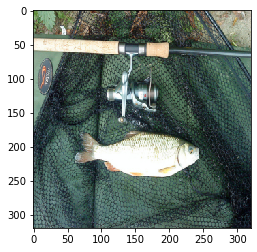

In [12]:
# plt.imshow(data_loader_a.dataset[88][0].permute(1,2,0))
plt.imshow(imagenet_data[35][0].permute(1,2,0))
print(data_loader_a.dataset)

print(imagenet_data_a[1][0].shape)

## Load pretrained network (resnet152)

In [13]:

num_classes = len(WIDERFace_CLASSES) + 1 # +1 background
net = build_ssd('test', cfg['min_dim'], num_classes) # initialize SSD
net.load_state_dict(torch.load(trained_model))

if torch.cuda.device_count() > 1:  
    net = nn.DataParallel(net) #enabling data parallelism

net.cuda()

net.eval()
print('Finished loading model!')

loading pretrained resnet model
Finished loading model!


In [14]:
indices = np.arange(0,10240)
# imagenet_data_a = torch.utils.data.Subset(imagenet_dataset_a, indices)
# data_loader_a = torch.utils.data.DataLoader(imagenet_data_a,
#                                           batch_size=BATCH_SIZE,
#                                           shuffle=False,
#                                           num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

imagenet_data_a.indices =  indices

len(data_loader_a.dataset)

10240

In [15]:

index_array = np.append(np.arange(start_idx, length_imagenet, subset_size), length_imagenet)
print(index_array, len(index_array))

[    0 50000] 2


In [16]:
# # index_array = index_array/100
# # index_array = index_array.astype('int32')
# # i = 10
# # st = index_array[i]
# # end = index_array[i+1]
# # print('iteration number ',str(i),' finished')



# index_array = np.delete(index_array, 0)
# print(index_array)

## Inference on Batches

In [ ]:
for i in range(len(index_array)-1):
    start = index_array[i]
    end = index_array[i+1]
    indices = np.arange(start, end)
    imagenet_data_a.indices =  indices
    all_dets = infer_data_loader(data_loader_a,net, means, thresh, visual_threshold, cuda, shrink, st, bt, max_im_shrink, small_box_thresh)
    joblib.dump(all_dets, 'imagenet_bboxes_'+split+'_'+str(start)+'_to_'+str(end)+'.pkl')
    print('iteration number ',str(i),' finished')

/home/suleman/anaconda/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/suleman/anaconda/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
data_loader_a = torch.utils.data.DataLoader(imagenet_data_a,
                                          batch_size=120,
                                          shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

In [ ]:
start = time.time()

all_dets = []

data = []

with torch.no_grad():
    for idx, b0 in enumerate(data_loader_a ):
    #         print(batch.shape, type(batch))
        end = time.time()
        print(end-start, idx)
        start = time.time()
        b0 = 255*b0[0].float() - means.float()
        b0 = Variable(b0)
        b0 = b0.cuda()
#         break
#         if idx == 0:
#             data = b0
#         else:
#             data = torch.cat((data,b0))
        
        b1 = b0.flip(-1)
        b2 = torch.nn.functional.interpolate(b0, scale_factor=st, mode='bilinear')
        b3 = torch.nn.functional.interpolate(b0, scale_factor=bt, mode='bilinear')
        
        
        
        det_0 = infer_batch(net, b0, means, thresh, cuda, shrink)

        
        det_1 = infer_batch(net, b1, means, thresh, cuda, shrink)

        
        det_s = infer_batch(net, b2, means, thresh, cuda, st)
                
        det_b1 = infer_batch(net, b3, means, thresh, cuda, bt)
        


#         b1 = torch.nn.functional.interpolate(b0, scale_factor=max_im_shrink, mode='bilinear')
#         det_b2 = infer_batch(net, b1, means, thresh, cuda, max_im_shrink)
#         dets_b = [np.row_stack(i) for i in zip(det_to_dets(det_b1, thresh), det_to_dets(det_b2, thresh) )]

        dets_b = det_to_dets(det_b1, thresh)

        dets_0 = det_to_dets(det_0, thresh)
        dets_1 = flip_batch(det_to_dets(det_1, thresh))
        dets_s = det_to_dets(det_s, thresh)
        
        index = [np.where(np.maximum(i[..., 2] - i[..., 0] + 1, i[..., 3] - i[..., 1] + 1) > small_box_thresh)[0] for i in dets_s]
        dets_s = [i[j, :] for i,j in zip(dets_s, index)]
        
        dets = [np.row_stack((i0, i1, i_s, i_b)) for i0, i1, i_s, i_b in zip(dets_0,dets_1,dets_s,dets_b)]
        
        all_dets = all_dets + [bbox_vote(det, visual_threshold) for det in dets]
        end = time.time()
        print(end-start, idx)
        break
        start = time.time()
        
        
        
                
end = time.time()
print('Total time taken is: ', end-start)

In [ ]:
print(b3)

In [ ]:
joblib.dump(all_dets, 'temp_save.pkl')

## Correct Boxes for Image Shape

In [ ]:
shapes = np.loadtxt('imagenet_shapes_0_to_100000.csv', delimiter=',')
shapes = shapes[indices]

In [ ]:
indices = np.arange(0,1000)
dets = all_dets[0:1000]

In [ ]:
shapes_ = np.repeat(shapes, 2,axis=1)
print(np.ones((shapes_.shape[0],1)).shape, shapes_.shape)
shapes_ = np.concatenate((shapes_/IMG_Size, np.ones((shapes_.shape[0],1))), axis=1)
print(shapes_.shape)

In [ ]:
for i, det in enumerate(dets):
    dets[i] = det * shapes_[i]

In [ ]:
dets

In [ ]:
dets = [np.row_stack((i0, i1, i_s, i_b)) for i0, i1, i_s, i_b in zip(dets_0,dets_1,dets_s,dets_b)]
visual_threshold = 0.95
all_dets = [bbox_vote(det, visual_threshold) for det in dets_b]

type(dets), len(dets)
type(dets_0[0]), len(dets_0)

In [ ]:
offset = 15
for i in range(16):
#     ax = plt.subplot(4,4,i+1)
    vis_detections(imagenet_data_a[i+offset][0].permute(1,2,0) , all_dets[i+offset] , 'img_id', 0.9, plot_only=True)
    print( all_dets[i+offset])
    
    
    
    
# plt.imshow(imagenet_data_a[0][0].permute(1,2,0) )

In [ ]:
all_dets[i+2]

## Experimental Code Below

In [ ]:

start = time.time()

all_dets = []

data = []



with torch.no_grad():
    for idx, (b0,b1,b2,b3,b4) in enumerate(zip(data_loader_a,data_loader_b,data_loader_c,data_loader_d,data_loader_e )):
    #         print(batch.shape, type(batch))
        
        b0 = b0[0]
        b1 = b1[0]
        b2 = b2[0]
        b3 = b3[0]
        b4 = b4[0]
        
        
        det_0 = infer_batch(net, b0, means, thresh, cuda, shrink)
        det_1 = infer_batch(net, b1, means, thresh, cuda, shrink)      
        det_s = infer_batch(net, b2, means, thresh, cuda, st)     
        det_b1 = infer_batch(net, b3, means, thresh, cuda, bt)
        det_b2 = infer_batch(net, b4, means, thresh, cuda, max_im_shrink)
        dets_b = [np.row_stack(i) for i in zip(det_to_dets(det_b1, thresh), det_to_dets(det_b2, thresh) )]
#         dets_b = det_to_dets(det_b1, thresh)
        # det_s post processing

        
        index = [np.where(np.maximum(i[..., 2] - i[..., 0] + 1, i[..., 3] - i[..., 1] + 1) > small_box_thresh)[0] for i in dets_s]
        dets_s = [i[j, :] for i,j in zip(dets_s, index)]

        

        dets = [np.row_stack((i0, i1, i_s, i_b)) for i0, i1, i_s, i_b in zip(dets_0,dets_1,dets_s,dets_b)]
        
        
        all_dets = all_dets + [bbox_vote(det) for det in dets]
        
        if idx == 100:
            joblib.dump(all_dets, 'imagenet_bbox_'+str(idx)+'.pkl')
            all_dets = []

        
        
        if (idx+1)  %1000 == 0:
            joblib.dump(all_dets, 'imagenet_bbox_'+str(idx)+'.pkl')
            all_dets = []
            
                
end = time.time()
print('Total time taken is: ', end-start)

In [ ]:
# imagenet_data_a.indices = np.arange(10000,20000)
# imagenet_data_a.indices = np.arange(0,10000)
# data_loader_a = torch.utils.data.DataLoader(imagenet_data_a,
#                                           batch_size=16,
#                                           shuffle=False,
#                                           num_workers=20, pin_memory=False)

start = time.time()

with torch.no_grad():
    for idx, (b0,b1,b2,b3,b4) in enumerate(zip(data_loader_a,data_loader_b,data_loader_c,data_loader_d,data_loader_e )):
    #         print(batch.shape, type(batch))
        
        b0 = b0[0]
        b1 = b1[0]
        b2 = b2[0]
        b3 = b3[0]
        b4 = b4[0]
        break
#     for idx, b0 in enumerate(data_loader_a):
#         b0 = b0[0]
#         break
#         if idx > 50:
#             break
    
end = time.time()

print('Time:', end - start)
plt.imshow(b0[0].permute(1,2,0))

In [ ]:
all_dets = []

data = []

start = time.time()

det_0 = infer_batch(net, b0, means, thresh, cuda, shrink)
det_1 = infer_batch(net, b1, means, thresh, cuda, shrink)      
det_s = infer_batch(net, b2, means, thresh, cuda, st)     
det_b1 = infer_batch(net, b3, means, thresh, cuda, bt)
# det_b2 = infer_batch(net, b4, means, thresh, cuda, max_im_shrink)
# dets_b = [np.row_stack(i) for i in zip(det_to_dets(det_b1, thresh), det_to_dets(det_b2, thresh) )]
dets_b = det_to_dets(det_b1, thresh)
# det_s post processing
dets_0 = det_to_dets(det_0, thresh)
dets_1 = flip_batch(det_to_dets(det_1, thresh))
dets_s = det_to_dets(det_s, thresh)

index = [np.where(np.maximum(i[..., 2] - i[..., 0] + 1, i[..., 3] - i[..., 1] + 1) > small_box_thresh)[0] for i in dets_s]
dets_s = [i[j, :] for i,j in zip(dets_s, index)]



dets = [np.row_stack((i0, i1, i_s, i_b)) for i0, i1, i_s, i_b in zip(dets_0,dets_1,dets_s,dets_b)]


all_dets = all_dets + [bbox_vote(det, thresh) for det in dets]


end = time.time()
print('Total time taken is: ', end-start)

In [ ]:
len(dets[0])

In [ ]:
# d = np.concatenate(data, axis=0)
# d.shape

# np.save('first352.npy', d)
# torch.save(data, 'pytorch_data.pkl')
# data = torch.load('pytorch_data.pkl')

# d = np.load('first352.npy')

data = data.cpu()

print(data.device)

In [ ]:

start = time.time()

all_dets = []

# data = []
b_size = 16

int_mode = 'nearest'

with torch.no_grad():
    for idx in range(10):
    #         print(batch.shape, type(batch))
#         b0 = torch.from_numpy(d[idx*16:(idx+1)*16,...])
        b0 = data[idx*16:(idx+1)*16,...]
        print(b0.device)
        
        max_im_shrink = 2000/IMG_Size

        shrink = 1
        print('start')
        dets0 = infer_batch(net, b0, means, thresh, cuda, shrink)
        print('stop')
        b1 = b0.flip(-1)
        print('start')
        dets1 = infer_flip_batch(net, b1, means, thresh, cuda, shrink)
        print('stop')
        st = 0.5
        b2 = torch.nn.functional.interpolate(b0, scale_factor=st, mode=int_mode)
        print('start')
        dets_s = infer_batch(net, b2, means, thresh, cuda, st)
        print('stop')
        index = [np.where(np.maximum(i[..., 2] - i[..., 0] + 1, i[..., 3] - i[..., 1] + 1) > 30)[0] for i in dets_s]
        dets_s = [i[j, :] for i,j in zip(dets_s, index)]

        bt = 2
        b3 = torch.nn.functional.interpolate(b0, scale_factor=bt, mode=int_mode)
        print('start3')
        dets_b = infer_batch(net, b3, means, thresh, cuda, bt)
        print('stop3')
        b4 = torch.nn.functional.interpolate(b0, scale_factor=max_im_shrink, mode=int_mode)
        print('start4')
        dets_b = [np.row_stack(i) for i in zip(dets_b, infer_batch(net, b4, means, thresh, cuda, max_im_shrink) )]
        print('stop4')
        dets = [np.row_stack((i0, i1, i_s, i_b)) for i0, i1, i_s, i_b in zip(dets0,dets1,dets_s,dets_b)]
        all_dets = all_dets + [bbox_vote(det) for det in dets]



end = time.time()
print('Total time taken is: ', end-start)

In [ ]:
for idx, batch in enumerate(data_loader_a):
    if idx == 0:
        break
        


In [ ]:
i = 1
plt.subplot(1,2,1)
plt.imshow(batch[0][i,...].permute(1,2,0))
bflip = batch[0].flip(-1)
plt.subplot(1,2,2)
plt.imshow(bflip[i,...].permute(1,2,0))

In [ ]:
up = torch.nn.functional.interpolate(batch[0], scale_factor=max_im_shrink)
up.shape

In [ ]:
i = 1
plt.subplot(1,2,1)
plt.imshow(batch[0][i,...].permute(1,2,0))
bflip = batch[0].flip(-1)
plt.subplot(1,2,2)
plt.imshow(up[i,...].permute(1,2,0))

In [ ]:
max_im_shrink = 2000/IMG_Size

In [ ]:
for idx, data in enumerate(data_loader):
    b0,b1,b2,b3,b4 = data
    if idx > 5:
        break
    

In [ ]:
start = time.time()
means = (104, 117, 123)

thresh = cfg['conf_thresh']
b0 = batch[0]

max_im_shrink = 2000/IMG_Size

shrink = 1
dets0 = infer_batch(net, b0, means, thresh, cuda, shrink)

b1 = b0.flip(-1)
dets1 = infer_flip_batch(net, b1, means, thresh, cuda, shrink)

st = 0.5
b1 = torch.nn.functional.interpolate(b0, scale_factor=st, mode='bilinear')
dets_s = infer_batch(net, b1, means, thresh, cuda, st)
index = [np.where(np.maximum(i[..., 2] - i[..., 0] + 1, i[..., 3] - i[..., 1] + 1) > 30)[0] for i in dets_s]
dets_s = [i[j, :] for i,j in zip(dets_s, index)]

bt = 2
b1 = torch.nn.functional.interpolate(b0, scale_factor=bt, mode='bilinear')
dets_b = infer_batch(net, b1, means, thresh, cuda, bt)

b1 = torch.nn.functional.interpolate(b0, scale_factor=max_im_shrink, mode='bilinear')
dets_b = [np.row_stack(i) for i in zip(dets_b, infer_batch(net, b1, means, thresh, cuda, max_im_shrink) )]

dets = [np.row_stack((i0, i1, i_s, i_b)) for i0, i1, i_s, i_b in zip(dets0,dets1,dets_s,dets_b)]
all_dets = all_dets + [bbox_vote(det) for det in dets]

end = time.time()

print(end-start)

## Perform inference on an image

### Select Image

In [ ]:
cuda = cuda
transform = TestBaseTransform((104, 117, 123))
thresh=cfg['conf_thresh']
img_id = 'face'

from_memory = True
data_loader = data_loader_b
img_num = 1

if from_memory:
#     img_root = '../face-detection-project-prakash/img.jpg'
    img_root = './data/worlds-largest-selfie.jpg'
    path = img_root
    img = cv2.imread(path, cv2.IMREAD_COLOR)
else: 
    img = data_loader.dataset[img_num][0].permute(1,2,0).numpy()
    img = img[:,:,::-1]*255



In [ ]:
max_im_shrink = ( (2000.0*2000.0) / (img.shape[0] * img.shape[1])) ** 0.5
shrink = max_im_shrink if max_im_shrink < 1 else 1
x = torch.from_numpy(transform(img)[0]).permute(2, 0, 1)


print(x)

### Inference Code

In [ ]:
max_im_shrink = ( (2000.0*2000.0) / (img.shape[0] * img.shape[1])) ** 0.5
shrink = max_im_shrink if max_im_shrink < 1 else 1



det0 = infer(net , img , transform , thresh , cuda , shrink)
det1 = infer_flip(net , img , transform , thresh , cuda , shrink)


# shrink detecting and shrink only detect big face
st = 0.5 if max_im_shrink >= 0.75 else 0.5 * max_im_shrink
det_s = infer(net , img , transform , thresh , cuda , st)
index = np.where(np.maximum(det_s[:, 2] - det_s[:, 0] + 1, det_s[:, 3] - det_s[:, 1] + 1) > 30)[0]
det_s = det_s[index, :]


# enlarge one times
factor = 2
bt = min(factor, max_im_shrink) if max_im_shrink > 1 else (st + max_im_shrink) / 2
det_b = infer(net , img , transform , thresh , cuda , bt)


# enlarge small iamge x times for small face
if max_im_shrink > factor:
    bt *= factor
    while bt < max_im_shrink:
        det_b = np.row_stack((det_b, infer(net , img , transform , thresh , cuda , bt)))
        bt *= factor
    det_b = np.row_stack((det_b, infer(net , img , transform , thresh , cuda , max_im_shrink) ))


    
if bt > 1:
    index = np.where(np.minimum(det_b[:, 2] - det_b[:, 0] + 1, det_b[:, 3] - det_b[:, 1] + 1) < 100)[0]
    det_b = det_b[index, :]
else:
    index = np.where(np.maximum(det_b[:, 2] - det_b[:, 0] + 1, det_b[:, 3] - det_b[:, 1] + 1) > 30)[0]
    det_b = det_b[index, :]

    
det = np.row_stack((det0, det1, det_s, det_b))
det = bbox_vote(det)

### Visualize output

In [ ]:
vis_detections(img.astype(np.int32) , det , 'img_id', 0.5, plot_only=True)

In [ ]:
img_orig = data_loader_a.dataset[img_num][0].permute(1,2,0).numpy()
img_orig = img_orig[:,:,::-1]*255
scale = np.array(img_orig.shape[0:2])/IMG_Size
scale = np.tile(scale[::-1], 2)
print(scale)
det_mod = det.copy()
det_mod[:,:4] = det_mod[:,:4]*scale
print(det, det_mod)

In [ ]:
img_num = 0
img_orig = b0[img_num].permute(1,2,0).numpy()
img_orig = img_orig[:,:,::-1]*255
scale = np.array(img_orig.shape[0:2])/IMG_Size
scale = np.tile(scale[::-1], 2)
print(scale)
det_mod = dets[img_num].copy()
det_mod[:,:4] = det_mod[:,:4]*scale
print( dets[img_num][:,4])

In [ ]:
vis_detections(img_orig.astype(np.int32) , det_mod , 'img_id', 0.9, plot_only=True)

In [ ]:
plt.imshow(img_orig.astype(np.int32))

## Create Imagenet Shape Vector and Save it 
#### for fixing box sizes after inference

In [ ]:
start_idx = 0
batch_size = 100000
end_idx = start_idx + batch_size

for j in range(10):
    shapes = []
    for i, (im, _) in enumerate(imagenet_data_a):
        if i < start_idx:
            continue
        shapes.append(im.numpy().shape[1:])
        if i>=end_idx:
            start_idx = end_idx
            end_idx = start_idx + batch_size
            break
        
    shapes = np.array(shapes)
    np.savetxt('imagenet_shapes_'+str(start_idx)+'_to_'+str(end_idx)+'.csv',
                       shapes, fmt='%d',delimiter= ',')
    print('Saved image shapes starting between', start_idx, 'and', end_idx)

In [ ]:
mini = torch.utils.data.Subset(data_loader_a.dataset, )

In [ ]:
plt.imshow(data_loader.dataset[0][0].permute(1,2,0))
x = data_loader.dataset[0][0]
x = Variable(x.unsqueeze(0)).cuda()
print(data_loader.dataset[0][0].permute(1,2,0))

In [ ]:
y_t = net(x)

In [ ]:
detections = y_t.data

print(detections.shape)

In [ ]:
det = []
for i in range(detections.size(1)):
    j = 0
    while detections[0, i, j, 0] >= 0.1:
        score = detections[0, i, j, 0]
        score = score.cpu().numpy()
        #label_name = labelmap[i-1]
        pt = (detections[0, i, j, 1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1], pt[2], pt[3]) 
        det.append([pt[0], pt[1], pt[2], pt[3], score])
        j += 1
if (len(det)) == 0:
    det = [ [0.1,0.1,0.2,0.2,0.01] ]
det = np.array(det)

In [ ]:
print(b4.shape)

In [ ]:
print(len(dets), len(dets[0]))
for i in range(len(dets)):
    print(len(dets[i]))

In [ ]:
import joblib
joblib.dump(dets, 'boxes.pkl')

In [ ]:
print(batch[0].shape)
tfm = torch.from_numpy(np.array((104, 117, 123)))
tfm = tfm.unsqueeze(-1)
tfm = tfm.unsqueeze(-1)
print(tfm.shape)
# batch[0].type(torch.FloatTensor)*255- tfm.type(torch.FloatTensor)
x = batch[0].float()*255 - tfm.float()
x.shape


In [ ]:
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(batch[0][i].permute(1,2,0))
plt.subplots_adjust(left = 0.0, right = 2, wspace=0.0, top=2, bottom=0)



In [ ]:

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(data_loader_a.dataset[i][0].permute(1,2,0))
plt.subplots_adjust(left = 0.0, right = 2, wspace=0.0, top=2, bottom=0)

In [ ]:
import copy
imagenet_data_c = copy.copy(imagenet_data_a)
imagenet_data_c.transform = transform_b
imagenet_data_c.transform

In [ ]:
batch = batch[0]

In [ ]:

means = (104, 117, 123)
img_size = 640

# del x,  tfm
# torch.cuda.empty_cache()


with torch.no_grad():
    tfm = torch.from_numpy(np.array(means))
    tfm = tfm.unsqueeze(-1)
    tfm = tfm.unsqueeze(-1)

    x = 255*batch.float() - tfm.float()
    x = Variable(x)
    if cuda:
        x = x.cuda()

    y = net(x) 
    detections = y.data

    shrink = 1
    scale = torch.Tensor([img_size/shrink, img_size/shrink,
                                 img_size/shrink, img_size/shrink] )
    
    
    
    

In [ ]:
print(detections[:,0,:,:].shape, detections[:,1,:,:].shape)

temp = torch.cat([detections[:,0,:,:], detections[:,1,:,:]], dim=1)
temp.shape

score = temp[:,:,0]
score = score.unsqueeze(-1)
pt = temp[:,:,1:]*scale

print('asd', score.shape, pt.shape)

det = torch.cat([pt, score], dim=2)
# det = temp
print(det.shape)

In [ ]:
det_ = det.cpu().numpy()

dets = []

for i in range(det_.shape[0]):
    curr_det = det_[i,...]
    keep_index = np.where(curr_det[:,4] > 0)[0]
    curr_det = curr_det[keep_index, :]
    dets.append(curr_det)
    print(curr_det.shape, curr_det)
    
    
print(len(dets))

In [ ]:
chk_det = np.row_stack((det0, det1, det_s, det_b))

In [ ]:
chk_det.shape
order = chk_det[:, 4].ravel().argsort()[::-1]
print(order)

In [ ]:
# print(img, data_loader.dataset[0][0])
# print(np.max(img))
# plt.imshow(img)
img.shape